# Fitting a parabola with outliers

Consider an $N \times 1$ data vector $\mathbf{d}$ whose $i$th element $d_{i}$ is given by:

$$
d_{i} = f(x_{i}) \: ,
$$

where $f(x)$ is an unknown function depending on the variable $x$. Besides, consider that each $d_{i}$ can be approximated as follows:

$$
d_{i} \approx a + b \, x_{i} + c \, x_{i}^{2} \: ,
$$

where $a$, $b$, and $c$ are unknown constants.

### Simulating noise-free and noise-corrupted data with outliers

The noise are generated by using the routine [`numpy.random.normal`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# number of data
N = 50

# coordinates of the data
x = np.linspace(0., 30., N)

xmax = np.max(x)
xmin = np.min(x)
Dx = xmax - xmin

# true constants a and b
a_true = -5.
b_true = 0.1
c_true = 0.01

# noise-free data vector
data = a_true + b_true*x + c_true*x*x

dmin = np.min(data)
dmax = np.max(data)
Dd = dmax - dmin

Create outliers close to x = 20.

In [3]:
outliers_mask = (x >= 25) & (x <= 28)

In [4]:
x[outliers_mask]

array([25.10204082, 25.71428571, 26.32653061, 26.93877551, 27.55102041])

In [5]:
data[outliers_mask] -= 8

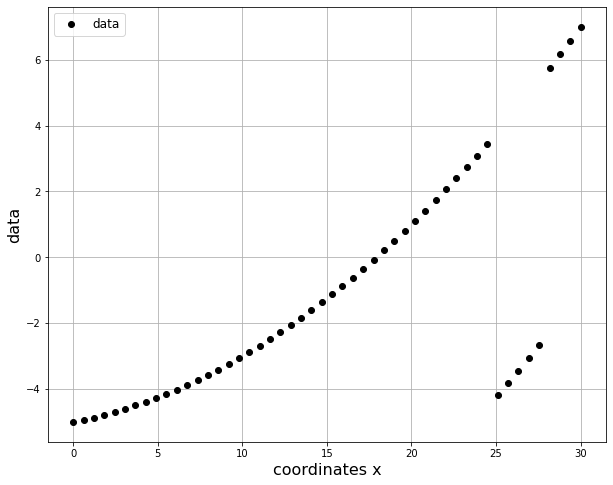

In [6]:
plt.close('all')
plt.figure(figsize=(10,8))
plt.plot(x, data, 'ko', label='data')
plt.xlim(xmin - 0.05*Dx, xmax + 0.05*Dx)
plt.ylim(dmin - 0.05*Dd, dmax + 0.05*Dd)
plt.xlabel('coordinates x', fontsize=16)
plt.ylabel('data', fontsize=16)
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.show()

### Compute the matrix $\mathbf{A}$

In [7]:
A = np.polynomial.polynomial.polyvander(x, deg=2)

### Estimate the parameters

In [8]:
# Ordinary least-squares solution
ATA = np.dot(A.T, A)
ATd = np.dot(A.T, data)
p_LS = np.linalg.solve(ATA, ATd)

In [15]:
# Weighted least-squares solution
W = np.ones_like(data)
W[outliers_mask] = 0.2
W = np.diag(W)
ATWA = np.linalg.multi_dot([A.T, W, A])
ATWd = np.linalg.multi_dot([A.T, W, data])
p_WLS = np.linalg.solve(ATWA, ATWd)

In [10]:
# IRLS
itmax = 30
tol = 0.001
p0 = p_LS.copy()
p_IRLS = np.empty_like(p0)
for i in range(itmax):
    r0 = data - np.dot(A, p0)
    R = np.diag(1/np.abs(r0))
    R[r0 < 1e-10] = 1e-10
    ATRA = np.linalg.multi_dot([A.T, R, A])
    ATRd = np.linalg.multi_dot([A.T, R, data])
    p_IRLS = np.linalg.solve(ATRA, ATRd)
    
    # convergence
    norm_diff = np.linalg.norm(p_IRLS-p0)
    norm_p_IRLS = np.linalg.norm(p_IRLS)
    convergence = norm_diff/(1 + norm_p_IRLS)
    if convergence < tol:
        break
    else:
        p0 = p_IRLS.copy()

### Computed predicted data

In [11]:
# Ordinary least-squares solution
y_LS = p_LS[0] + p_LS[1]*x + p_LS[2]*x*x

In [16]:
# Weighted least-squares solution
y_WLS = p_WLS[0] + p_WLS[1]*x + p_WLS[2]*x*x

In [13]:
# IRLS
y_IRLS = p_IRLS[0] + p_IRLS[1]*x + p_IRLS[2]*x*x

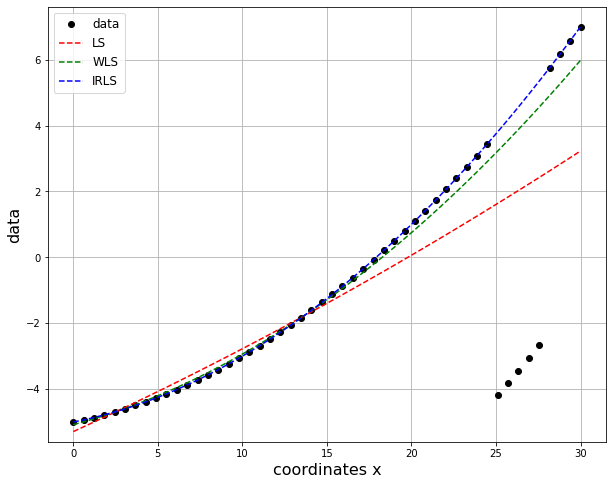

In [17]:
plt.close('all')
plt.figure(figsize=(10,8))
plt.plot(x, data, 'ko', label='data')
plt.plot(x, y_LS, 'r--', label='LS')
plt.plot(x, y_WLS, 'g--', label='WLS')
plt.plot(x, y_IRLS, 'b--', label='IRLS')
plt.xlim(xmin - 0.05*Dx, xmax + 0.05*Dx)
plt.ylim(dmin - 0.05*Dd, dmax + 0.05*Dd)
plt.xlabel('coordinates x', fontsize=16)
plt.ylabel('data', fontsize=16)
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.show()